In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2023-06-30 17:15:26.224489: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 17:15:26.226715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 17:15:26.270049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 17:15:26.271910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 17:15:26.948660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.12.0


In [14]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

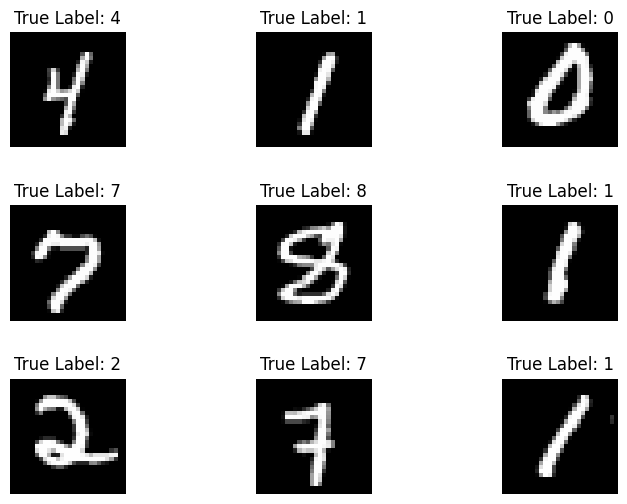

In [9]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

The MNIST dataset is a dataset of handwritten digits. The data itself is a 2-d grid of values. 

In [15]:
def preprocess(x, y): 

    x = tf.reshape(x, shape = [-1, 784])
    x = x / 255
    return x, y



In [16]:
# We are applying this to each element of our data
train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

In [12]:
train_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
def xavier_init(shape): 

    in_dim, out_dim = shape
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    weight_vals = tf.random.uniform(shape = (in_dim, out_dim), minval = -xavier_lim, maxval = xavier_lim, seed = 22)

    return weight_vals

In [20]:
xavier_init((3, 4))

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.7683675 ,  0.18148452,  0.8120956 , -0.34962475],
       [ 0.1041134 ,  0.7772344 , -0.68309605, -0.7322771 ],
       [-0.16226923,  0.27974933, -0.46499822,  0.5776419 ]],
      dtype=float32)>

We are going to make a Dense layer class to illustrate the concepts

In [21]:
class DenseLayer(tf.Module): 

    def __init__(self, out_dim, weight_init = xavier_init, activation = tf.identity): 

        self.out_dim = out_dim 
        self.weight_init = weight_init 
        self.activation = activation 
        self.built = False 

    def __call__(self, x): 
        if not self.built: 

            # Inferring the dimension from the first call 
            self.in_dim = x.shape[1]

            self.w = tf.Variable(xavier_init(shape = (self.in_dim, self.out_dim)))
            self.b = tf.Variable(tf.zeros(shape = (self.out_dim, )))
            self.built = True

        # We do our final summation here and send out the activation
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)  
    


In [22]:
class MLP(tf.Module): 

    def __init__(self, layers): 
        self.layers = layers 

    @tf.function 
    def __call__(self, x, preds = False): 

        for layer in self.layers: 
            x = layer(x)

        return x
    


We are going to create a model which has this architecture
* Relu(784, 700)
* Relu(700, 500)
* Softmax(500, 10)



In [23]:
hidden_layer_1_size = 700 
hidden_layer_2_size = 500 
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [24]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [25]:
class Adam: 

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7): 
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.learning_rate = learning_rate
        self.ep = ep

        self.t = 1. 
        self.v_dvar, self.s_dvar = [], [] 
        self.built = False 

    def apply_gradients(self, grads, vars): 
        # Initializing these variables on the first call
        if not self.built: 
            for var in vars: 
                v = tf.Variable(tf.zeros(shape = var.shape))
                s = tf.Variable(tf.zeros(shape = var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True

        # Update the model variables given the gradients
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
            self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
            v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
            var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))

        self.t += 1.
        return
                

In [26]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)s
  return batch_loss, batch_acc

In [27]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [28]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

2023-06-30 17:35:09.684823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-30 17:35:09.685535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-30 17:35:19.619654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{nod

Epoch: 0
Training loss: 0.223, Training accuracy: 0.934
Validation loss: 0.120, Validation accuracy: 0.963
Epoch: 1
Training loss: 0.080, Training accuracy: 0.975
Validation loss: 0.098, Validation accuracy: 0.971
Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.090, Validation accuracy: 0.975
Epoch: 3
Training loss: 0.035, Training accuracy: 0.989
Validation loss: 0.115, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.025, Training accuracy: 0.992
Validation loss: 0.093, Validation accuracy: 0.977
Epoch: 5
Training loss: 0.022, Training accuracy: 0.993
Validation loss: 0.103, Validation accuracy: 0.974
Epoch: 6
Training loss: 0.019, Training accuracy: 0.993
Validation loss: 0.100, Validation accuracy: 0.977
Epoch: 7
Training loss: 0.017, Training accuracy: 0.995
Validation loss: 0.109, Validation accuracy: 0.976
Epoch: 8
Training loss: 0.015, Training accuracy: 0.995
Validation loss: 0.091, Validation accuracy: 0.981
Epoch: 9
Training loss: 0.013, Traini